# Volatility timing


* You guys learned in 411 that a mean-variance investor invests in the risky asset proportionally to the risk-return trade-off

$$W_t=\frac{\mu_t}{\gamma \sigma_t^2}$$

* Measuring variation in $\mu_t$, the expected excess return on the market is really hard 

   * There are theoretically motivated ways to do it, which we will discuss later, but they are not great empirically

* But measuring variaiton in volatility is much easier because volatility periods tend to cluster together

* Lets download daily stock market data to show this visually

### Download data from WRDS

* We can download data directly from the WRDS (Wharton Reseach Data Services ) server

* If you want you can get a login to get acess to it as well. All you need is to follow the steps

https://wrds-web.wharton.upenn.edu/wrds/?register=1

* Anyone doing serious quant work needs a way to get a lot of data quickly. 

* WRDS has plenty of the basic data sources

In [ ]:
# install packages
!pip install wrds
!pip install psycopg2

In [32]:
import datetime as dt
import wrds
import psycopg2 
from dateutil.relativedelta import *


# connect with their server
conn=wrds.Connection()

# get the value-weighted market returns and date from the data base crsp.dsi
mkt_d = conn.raw_sql("""
                      select a.date, a.vwretd
                      from crsp.dsi as a
                      """) 
# get the risk-free rate
rf_d = conn.raw_sql("""
                      select a.date, a.rf
                      from ff.factors_daily as a
                      """)
# save data locally
#rf_d.to_csv('E:/Dropbox/Public/Fin418/Data/rf_d.csv')
#mkt_d.to_csv('E:/Dropbox/Public/Fin418/Data/mk_d.csv')

Enter your WRDS username [Alan Moreira]:moreira5
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.


Exception during reset or similar
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\engine\default.py", line 543, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.



Loading library list...
Done


In [31]:
# alternatively simply import from dropbox or download from blackboard as usual

rf_d=pd.read_csv('https://www.dropbox.com/s/85n50ul6of2fsca/rf_d.csv?dl=1')
mk_d=pd.read_csv('https://www.dropbox.com/s/ns191hnic5gpx13/mk_d.csv?dl=1')

In [33]:
mkt_d.tail()

,date,vwretd
24788,2019-12-24,0.000379
24789,2019-12-26,0.004618
24790,2019-12-27,-0.000643
24791,2019-12-30,-0.005108
24792,2019-12-31,0.002965


In [34]:
rf_d.tail()

,date,rf
24849,2020-10-26,0.0
24850,2020-10-27,0.0
24851,2020-10-28,0.0
24852,2020-10-29,0.0
24853,2020-10-30,0.0


In [35]:
# this set the index
mkt_d=mkt_d.set_index(['date'])

mkt_d=mkt_d.set_index(pd.to_datetime(mkt_d.index),'date')

rf_d=rf_d.set_index(['date'])

rf_d=rf_d.set_index(pd.to_datetime(rf_d.index),'date')

# we merge

daily=mkt_d.merge(rf_d,how='left',left_index=True,right_index=True)
daily.tail()

,vwretd,rf
date,,
2019-12-24,0.000379,0.00007
2019-12-26,0.004618,0.00007
2019-12-27,-0.000643,0.00007
2019-12-30,-0.005108,0.00007
2019-12-31,0.002965,0.00007


### We have daily data. How to construct monthly realized variance?


You basically use pandas time series function that shifts all dates to the end of the month, so this way you are technically grouping by the end of the month day.

In [39]:
daily.index

DatetimeIndex(['1925-12-31', '1926-01-02', '1926-01-04', '1926-01-05',
               '1926-01-06', '1926-01-07', '1926-01-08', '1926-01-09',
               '1926-01-11', '1926-01-12',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='date', length=24793, freq=None)

In [38]:
daily.index+MonthEnd(0)

DatetimeIndex(['1925-12-31', '1926-01-31', '1926-01-31', '1926-01-31',
               '1926-01-31', '1926-01-31', '1926-01-31', '1926-01-31',
               '1926-01-31', '1926-01-31',
               ...
               '2019-12-31', '2019-12-31', '2019-12-31', '2019-12-31',
               '2019-12-31', '2019-12-31', '2019-12-31', '2019-12-31',
               '2019-12-31', '2019-12-31'],
              dtype='datetime64[ns]', name='date', length=24793, freq=None)

In [40]:
from pandas.tseries.offsets import MonthEnd

# We denote `realized variance` for the market return as `RV`
RV=daily[['vwretd']].groupby(daily.index+MonthEnd(0)).var()
# rename column to clarify
RV=RV.rename(columns={'vwretd':'RV'})
RV.tail()

,RV
date,
2019-08-31,0.000187
2019-09-30,0.000031
2019-10-31,0.000061
2019-11-30,0.000014
2019-12-31,0.000020


In [41]:
# Another way to groupby month
RV1=daily[['vwretd']].groupby(pd.Grouper(freq='M')).var()
RV1.tail()

,vwretd
date,
2019-08-31,0.000187
2019-09-30,0.000031
2019-10-31,0.000061
2019-11-30,0.000014
2019-12-31,0.000020


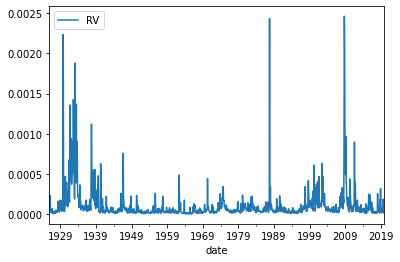

In [42]:
# plot the monthly realized variance
RV.plot()
plt.show()

### From signal to weights

* We now need to do the trading strategy, motivated by the fact that the realized variance in month t is a good proxy for the expected variance in month t+1 (see plot above!)

* So we will form the following strategy:
  * weight on the market:
  $$W_t=c\frac{1}{RV_t}=\frac{\mu}{\gamma RV_t}$$
  * weight on the risk-free rate: $1-W_t$

* $c$ controls how levered is the strategy on average.

* As we saw before all timing strategies involved some in and out of the market, but you also need to determine the average position. That is the role of $c$.

* For example: 
   - Lets set $c$ such that the leverage is 4 when the annualized standard deviation is 4% (which is equivalent to a daily variance of $RV=0.04^2/252$)
   - leverage is $W_t-1$ (you borrow by shorting the risk-free rate)
  $$W_t-1=\frac{c}{RV_t}-1\leq 4$$
   - So $c= 5 RV_t=5*0.04^2/252$

In [54]:
# calculate weights for the risky assets (market)
c=(5*(0.04**2)/252)
RV['W']=c/RV.RV
c

3.1746031746031745e-05

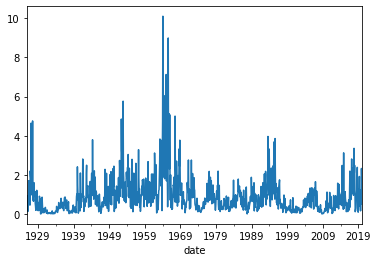

In [51]:
# plot the weights on the risky assets
RV.W.plot()
plt.show()

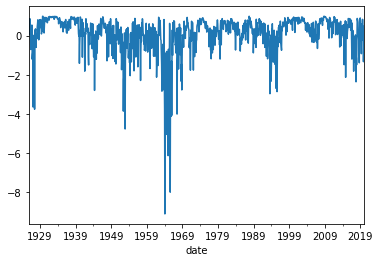

In [45]:
# plot the weights on the risk-free rate
(1-RV.W).plot()
plt.show()

In [53]:
RV.W.mean()

0.9241556985891785

In [56]:
daily

,vwretd,rf
date,,
1925-12-31,NaN,NaN
1926-01-02,0.005689,NaN
1926-01-04,0.000706,NaN
1926-01-05,-0.004821,NaN
1926-01-06,-0.000423,NaN
...,...,...
2019-12-24,0.000379,0.00007
2019-12-26,0.004618,0.00007
2019-12-27,-0.000643,0.00007


### Construct returns to the trategy

#### Aggregate daily returns to monthly

* Since the strategy will trade monthly, we now need to construct monthly returns

* we do that by cumulating daily returns within a month


In [57]:
# aggregate daily returns to monthly returns
Ret=(1+daily).groupby(daily.index+MonthEnd(0)).prod()-1
# rename columns to clarify
Ret=Ret.rename(columns={'vwretd':'Mkt','rf':'Rf'})
Ret.tail()

,Mkt,Rf
date,,
2019-08-31,-0.020256,0.001541
2019-09-30,0.015960,0.001802
2019-10-31,0.019249,0.001611
2019-11-30,0.034953,0.001201
2019-12-31,0.028492,0.001471


In [58]:
RV.tail()

,RV,W
date,,
2019-08-31,0.000187,0.170048
2019-09-30,0.000031,1.036153
2019-10-31,0.000061,0.521629
2019-11-30,0.000014,2.331902
2019-12-31,0.000020,1.594953


In [59]:
# Merge Ret (monthly return) with RV (realized variance and weights)
df=RV.merge(Ret,how='left',left_index=True,right_index=True)
df.tail()

,RV,W,Mkt,Rf
date,,,,
2019-08-31,0.000187,0.170048,-0.020256,0.001541
2019-09-30,0.000031,1.036153,0.015960,0.001802
2019-10-31,0.000061,0.521629,0.019249,0.001611
2019-11-30,0.000014,2.331902,0.034953,0.001201
2019-12-31,0.000020,1.594953,0.028492,0.001471


#### Construct strategy returns

* Now to construct the strategy return recall that we use the relaized variance in month t to buy the market at the closing of month t and earn the return accrued in month t+1

* So we need to lag our weights, or lead the returns

* I will call the strategy as $\textbf{VMS}$ (Volatility Managed Strategy)

In [61]:
df.W

date
1925-12-31         NaN
1926-01-31    0.919672
1926-02-28    0.708324
1926-03-31    0.138235
1926-04-30    0.586952
                ...   
2019-08-31    0.170048
2019-09-30    1.036153
2019-10-31    0.521629
2019-11-30    2.331902
2019-12-31    1.594953
Name: W, Length: 1129, dtype: float64

In [60]:
df.W.shift(1)

date
1925-12-31         NaN
1926-01-31         NaN
1926-02-28    0.919672
1926-03-31    0.708324
1926-04-30    0.138235
                ...   
2019-08-31    1.235581
2019-09-30    0.170048
2019-10-31    1.036153
2019-11-30    0.521629
2019-12-31    2.331902
Name: W, Length: 1129, dtype: float64

In [63]:
df.W.shift(1)+(1-df.W.shift(1))

date
1925-12-31    NaN
1926-01-31    NaN
1926-02-28    1.0
1926-03-31    1.0
1926-04-30    1.0
             ... 
2019-08-31    1.0
2019-09-30    1.0
2019-10-31    1.0
2019-11-30    1.0
2019-12-31    1.0
Name: W, Length: 1129, dtype: float64

In [64]:
df['VMS']=df.W.shift(1)*df.Mkt+(1-df.W.shift(1))*df.Rf

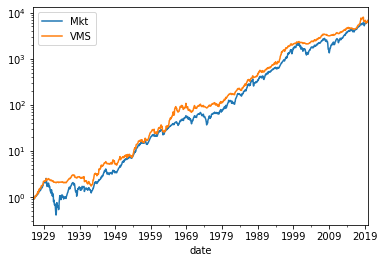

In [65]:
(df[['Mkt','VMS']]+1).cumprod().plot(logy=True)
plt.show()

In [66]:
df[['Mkt','VMS']].mean()

Mkt    0.009239
VMS    0.008606
dtype: float64

In [67]:
df[['Mkt','VMS']].std()

Mkt    0.053142
VMS    0.039161
dtype: float64

Sharpe ratio

In [68]:
(df[['Mkt','VMS']].subtract(df.Rf,axis=0).mean()/df[['Mkt','VMS']].std())*12**0.5

Mkt    0.425594
VMS    0.521141
dtype: float64

Tail risk

In [70]:
df[['Mkt','VMS']].quantile(q=0.005)

Mkt   -0.188058
VMS   -0.134315
Name: 0.005, dtype: float64

* What are other natural measures of risk to look at?

* Does any of this mean that VMS is a good/bad idea?

* What does this mean for a mean-variance investor that can borrow and lend at the risk-free rate and must choose between investing in the risk-free and the market or the risk-free and VMS?

* Is there a degree of risk aversion that would make the investor prefer Market over VMS?

* What if the investor could invest in all three assets? would he ever invest in the market or only on vms?

- This was just an example!

- There are a lot of timing strategies

- I like this one, becuase I (and Tyler Muir) came up with it. (https://www.google.com/url?q=https%3A%2F%2Fwww.dropbox.com%2Fs%2F022escr52x9oe51%2FVolPortfolios_published.pdf%3Fdl%3D0&sa=D&sntz=1&usg=AFQjCNGMECt2zp77lDfZRGJlkXQbGmqn1A)

